In [1]:
import sys

# Set the sys path to the main directory of the project
MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils.load import load_data
from utils.params import set_param

# Params for downsampling (specific to the dataset)
WINDOW = int(1e2)  # use 1e2
STEP = int(1e2)  # use 1e2

# Number of timesteps to display when rendering graphs
SECONDS_TO_DISPLAY = 200

In [3]:
# exp = 'b726'
# exp = 'b698'
# exp = 'i417'
# exp = 'p4679'
exp = "p4581"
# exp = 'cascadia'
# exp = 'sim_b726'
# exp = 'sim_b698'
# exp = 'sim_i417'

params = set_param(exp)

dirs = {"main": MAIN_DICT}
dirs["data"] = dirs["main"] + "/data/" + params["dir_data"]

X, _, t, _, _ = load_data(exp, dirs, params)

# Put the shear stress (X) and time (t) into a pandas dataframe to allow
# us to work with it more easily and carry out downsampling

# In numpy, the shape of an array is a tuple that gives the size of each
# dimension. The shape `(200010, 1)` means that the array `X` is a 2D array with
# 200010 rows and 1 column. The shape `(200010,)` means that the array `t` is a
# 1D array with 200010 elements. The trailing comma is used to indicate that
# this is a tuple with one element. In other words, `t` is a 1D array (like a
# list), while `X` is a 2D array (like a list of lists, where each inner list
# has only one element).

print(X.shape)
print(t.shape)

# `t.reshape(-1, 1)` is reshaping the `t` array. The `-1` in reshape function is
# a placeholder for "figure out what the dimension should be based on the length
# of the array and the other dimensions". The `1` means we want `t` to have one
# column. So, `t.reshape(-1, 1)` is reshaping `t` to have one column and as many
# rows as needed to accommodate the data.

# We need to reshape `t` because `np.hstack` requires the arrays of the same
# dimensions.

# `np.hstack` horizontally stacks multiple arrays. In this case, it's stacking
# the arrays `X` and `t.reshape(-1, 1)` side by side. The result is a single 2D
# array where the first columns are from `X` and the last column is from `t`.

# The resulting 2D array is then turned into a pandas DataFrame, which is a 2D
# labeled data structure with columns of potentially different types.
ts_data = pd.DataFrame(np.hstack((X, t.reshape(-1, 1))), columns=["X", "t"])

ts_data.head()

(200010, 1)
(200010,)


,X,t
0,1.29911,0.000
1,1.29903,0.001
2,1.29853,0.002
3,1.29871,0.003
4,1.29854,0.004


Sample rate: 999.9950002499876 Hz


Text(0.5, 1.0, 'Shear stress vs time')

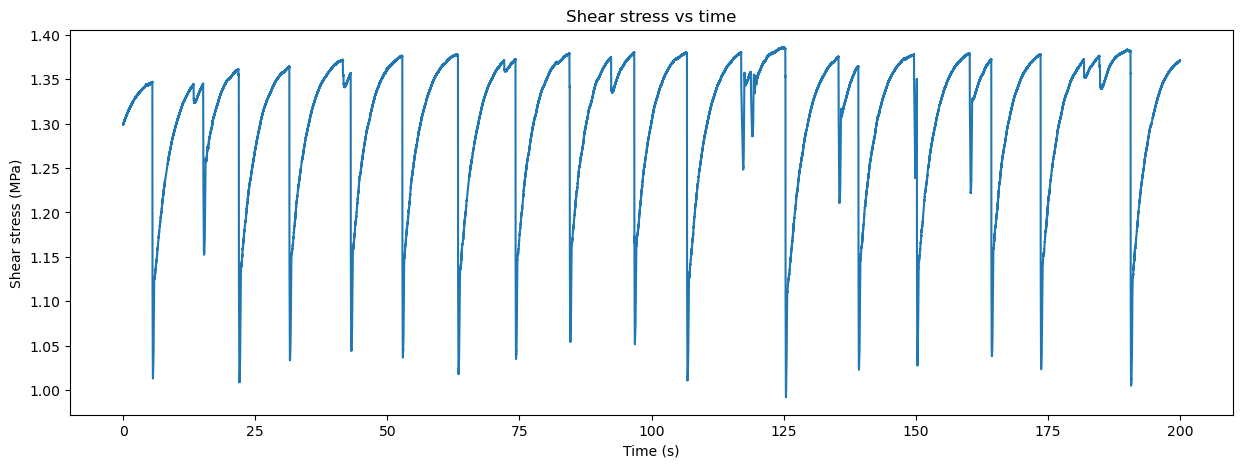

In [4]:
# Compute the sample rate from the time data
sample_rate = 1 / np.mean(np.diff(ts_data["t"]))
print("Sample rate:", sample_rate, "Hz")

# Sample rate as an integer (round to nearest integer)
sample_rate = int(np.round(sample_rate))

segment_in_sec = sample_rate * SECONDS_TO_DISPLAY

plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], ts_data["X"][:segment_in_sec])
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("Shear stress vs time")

# Not plotting derivative for now as signal is too noisy at this stage

Sample rate: 9.999950002499878 Hz


Text(0.5, 1.0, 'De-noised shear stress vs time')

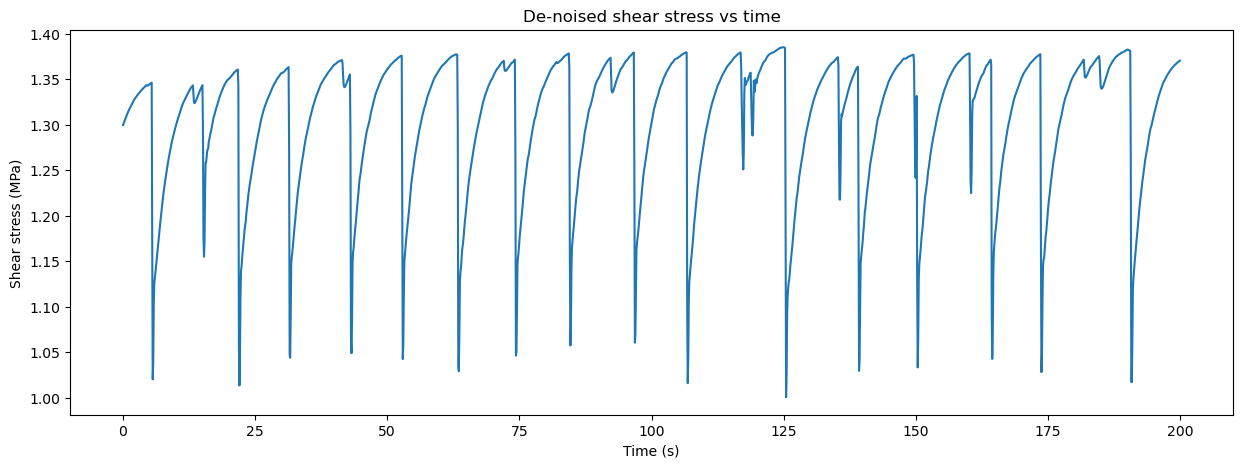

In [5]:
# Downsampling to remove noise (smoothing) and make forecasting easier (less
# points to predict)

# Apply a rolling window function with a specific window size and step size,
# then calculate the mean for each window. This is a way of downsampling the
# data, reducing its size and smoothing out short-term fluctuations.
# The dropna() function is used to remove any resulting missing values.
ts_data = ts_data.rolling(window=WINDOW, step=STEP).mean().dropna()

# Reset the index of the DataFrame. The 'drop=True' argument is used to avoid
# the old index being added as a column.
ts_data = ts_data.reset_index(drop=True)

# TODO: Wrap this in a util function
# Compute the sample rate from the time data post downsampling
sample_rate = 1 / np.mean(np.diff(ts_data["t"]))
print("Sample rate:", sample_rate, "Hz")

# Sample rate as an integer rounded to nearest integer
sample_rate = int(np.round(sample_rate))

segment_in_sec = sample_rate * SECONDS_TO_DISPLAY

# Plot the downsampled data
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], ts_data["X"][:segment_in_sec])
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("De-noised shear stress vs time")

Text(0.5, 1.0, 'Rate of change of de-noised shear stress vs time')

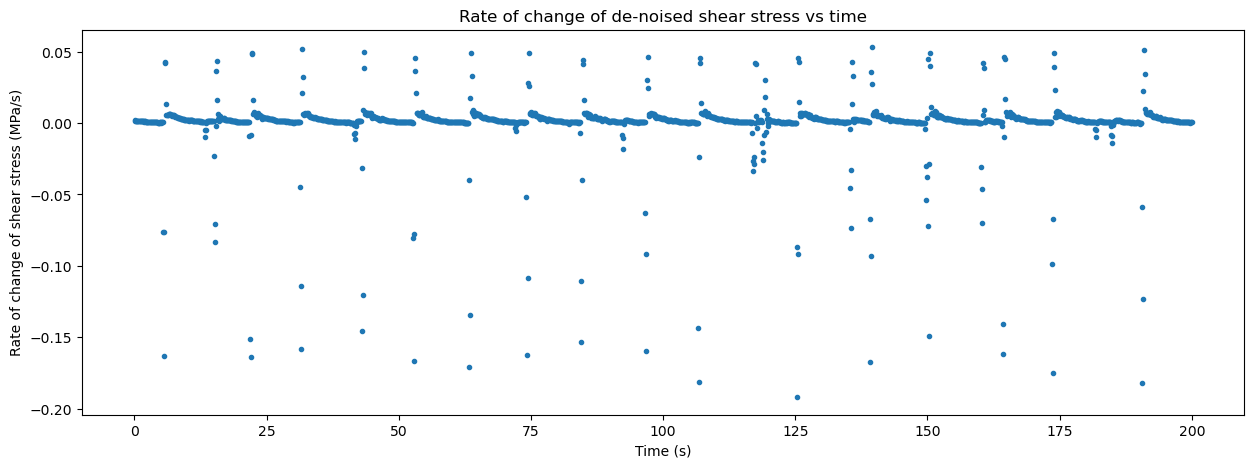

In [6]:
# Plot the derivative of the data (e.g. the rate of change of shear stress)
plt.figure(figsize=(15, 5))
plt.plot(
    ts_data["t"][:segment_in_sec],
    np.gradient(ts_data["X"][:segment_in_sec]),
    ".",
)
plt.xlabel("Time (s)")
plt.ylabel("Rate of change of shear stress (MPa/s)")
plt.title("Rate of change of de-noised shear stress vs time")

Text(0.5, 1.0, 'Log rate of change of de-noised shear stress vs time')

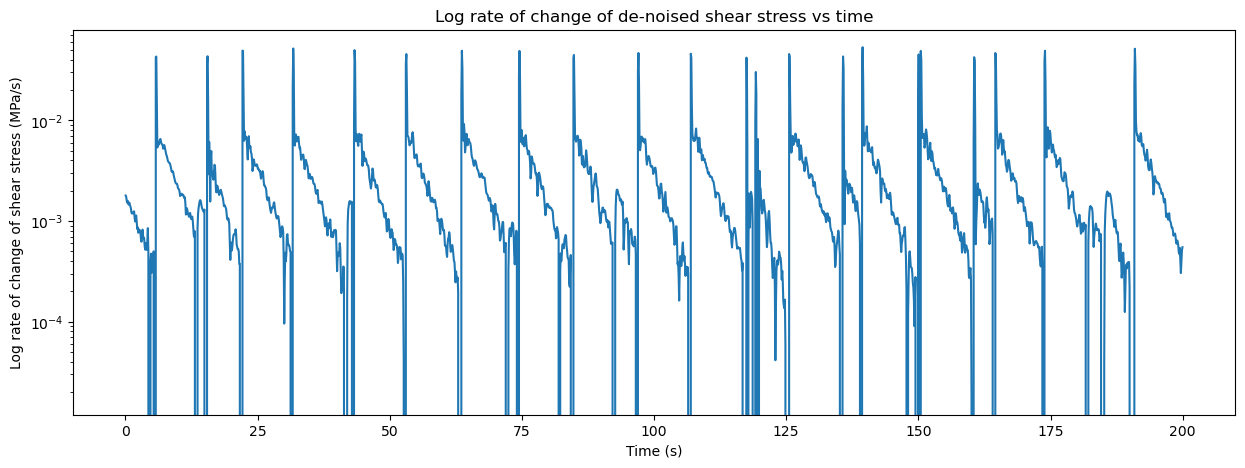

In [7]:
# Do a similar gradient plot but with a log scale (as in the above plot it is
# tricky to see the rate of change of shear stress during the stick phase)
plt.figure(figsize=(15, 5))
plt.plot(
    ts_data["t"][:segment_in_sec], np.gradient(ts_data["X"][:segment_in_sec])
)
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("Log rate of change of shear stress (MPa/s)")
plt.title("Log rate of change of de-noised shear stress vs time")

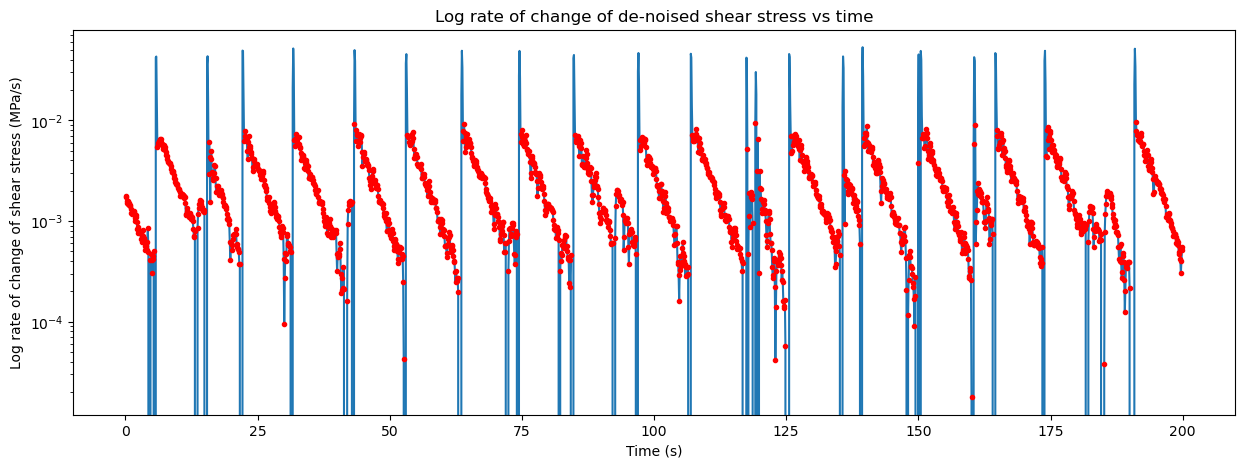

In [8]:
# Isolate and highlight the points where the rate of changes of shear stress
# gradually decreases toward 0 (i.e. the stick phase going towards the turning
# point)

# Query the indexes where the log rate of change is between 10^-2 and 10^-3

# Calculate the gradient and select indexes
gradient = np.gradient(ts_data["X"])
indexes = np.where((np.log10(np.abs(gradient))) < -2)[
    0
]  # FIXME: don't understand why this works

# Limit the number of data points to segment_in_sec
max_index = min(segment_in_sec, len(ts_data["t"]))
indexes = indexes[indexes < max_index]
gradient = gradient[:max_index]
time = ts_data["t"][:max_index]

# Plot the data
plt.figure(figsize=(15, 5))
plt.plot(time, gradient)
plt.plot(time[indexes], gradient[indexes], "r.")
plt.xlabel("Time (s)")
plt.ylabel("Log rate of change of shear stress (MPa/s)")
plt.title("Log rate of change of de-noised shear stress vs time")
plt.yscale("log")
plt.show()

Number of buckets: 23


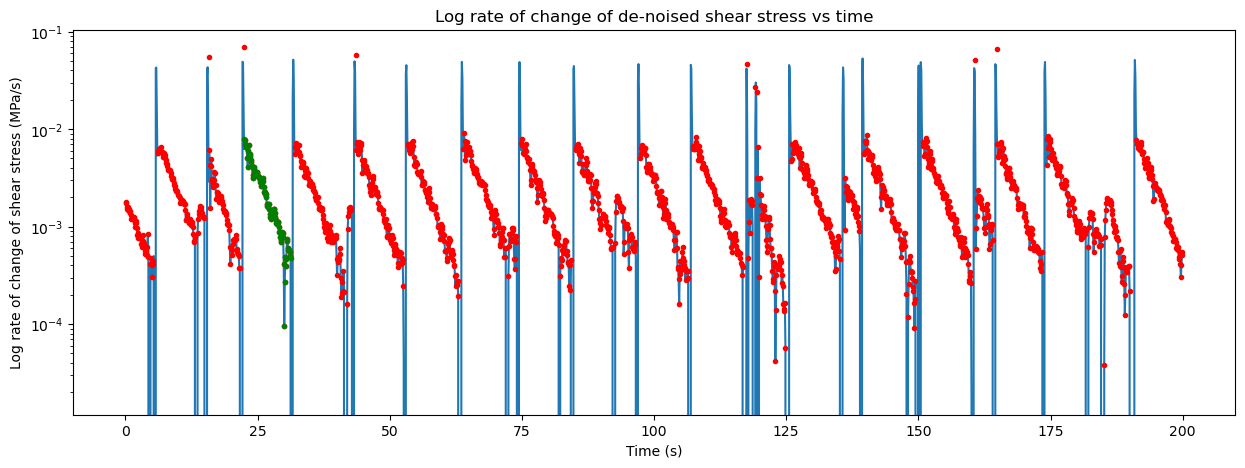

In [9]:
# Loop through the indexes, grouping points into buckets. This creates a bucket
# of indexes per stick phase of the signal.

# Start a new bucket if the difference between the current point and the
# previous point is greater than 1. Otherwise, add the current point to the
# current bucket.
buckets = []
for i in indexes:
    if len(buckets) == 0 or i - buckets[-1][-1] > 1:
        buckets.append([i])
    else:
        buckets[-1].append(i)

# Remove buckets with less than 10 points
buckets = [bucket for bucket in buckets if len(bucket) > 20]
# Replace negative indexes with 0
buckets = [[max(0, i) for i in bucket] for bucket in buckets]

print("Number of buckets:", len(buckets))

bucket = buckets[3]

# Plot the indexes in one of the buckets (bucket 3)
plt.figure(figsize=(15, 5))
plt.plot(
    ts_data["t"][:segment_in_sec], np.gradient(ts_data["X"][:segment_in_sec])
)
plt.plot(ts_data["t"][indexes], np.gradient(ts_data["X"][indexes]), "r.")
# Ployt the indexes in the first bucket
plt.plot(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), "g.")
plt.xlabel("Time (s)")
plt.ylabel("Log rate of change of shear stress (MPa/s)")
plt.title("Log rate of change of de-noised shear stress vs time")
plt.yscale("log")

Text(0.5, 1.0, 'De-noised shear stress vs time')

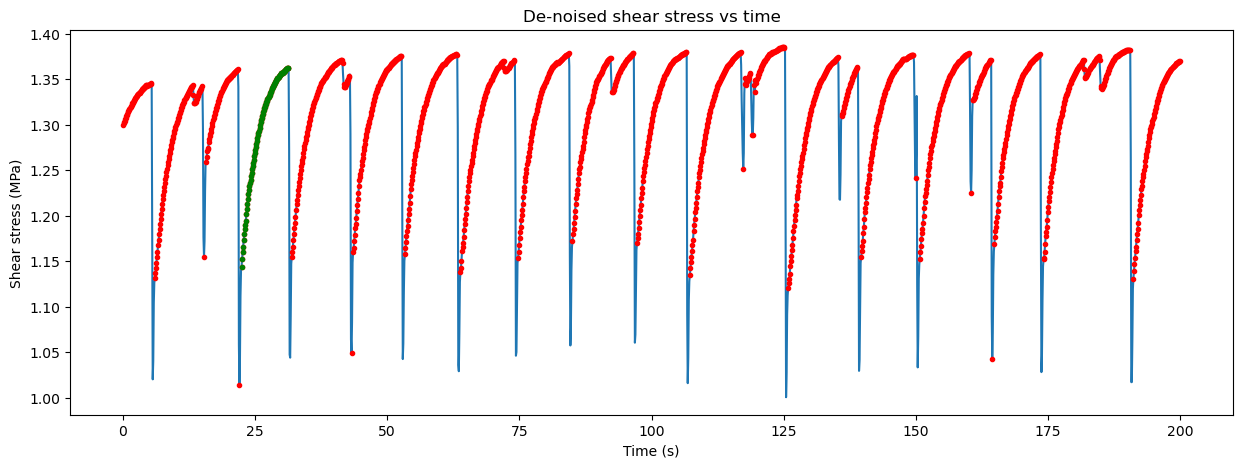

In [10]:
# Plot what this looks like on the shear stress plot
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], ts_data["X"][:segment_in_sec])
plt.plot(ts_data["t"][indexes], ts_data["X"][indexes], "r.")
plt.plot(ts_data["t"][bucket], ts_data["X"][bucket], "g.")
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("De-noised shear stress vs time")

[-0.00137446  0.01586586  1.29944486]
[-0.00393495  0.10367506  0.65540996]
[-0.00294947  0.12607139  0.01045935]
[-0.00329991  0.19956073 -1.65949366]
[-3.03874968e-03  2.43262979e-01 -3.50084302e+00]
[-3.36168696e-03  3.44260942e-01 -7.44212368e+00]
[-3.01808367e-03  3.71116191e-01 -1.00341050e+01]
[-3.33504266e-03  4.79670435e-01 -1.58777798e+01]
[-3.24071051e-03  5.35905545e-01 -2.07805145e+01]
[-4.10411020e-03  7.53609708e-01 -3.32266899e+01]
[-2.08978382e-03  4.06149039e-01 -1.83549806e+01]
[-3.26437942e-03  6.85280770e-01 -3.45878526e+01]
[-3.35247040e-03  7.73831034e-01 -4.32805746e+01]
[-1.68991531e-03  4.20427316e-01 -2.47648368e+01]
[-3.56130477e-03  9.54750151e-01 -6.26217733e+01]
[-2.47057906e-03  6.97713627e-01 -4.78835557e+01]
[-3.09162927e-03  9.13690957e-01 -6.61321055e+01]
[-3.27875597e-03  1.04047613e+00 -8.11715884e+01]
[-1.76754053e-03  5.88066068e-01 -4.75327215e+01]
[-3.51217698e-03  1.20974782e+00 -1.02800050e+02]
[-3.12011822e-03  1.13723904e+00 -1.02254155e+02

Text(0.5, 1.0, 'Distribution of curve parameter 3 (constant term)')

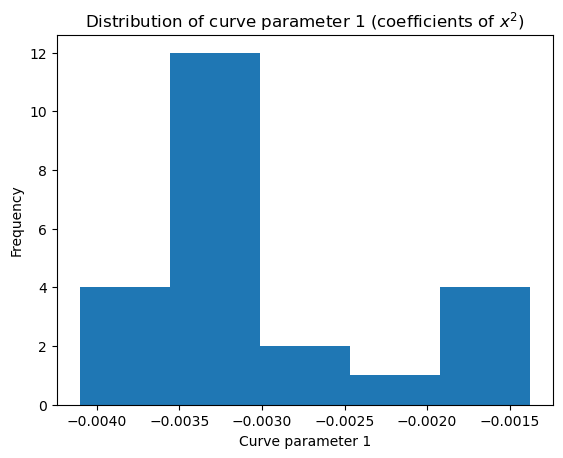

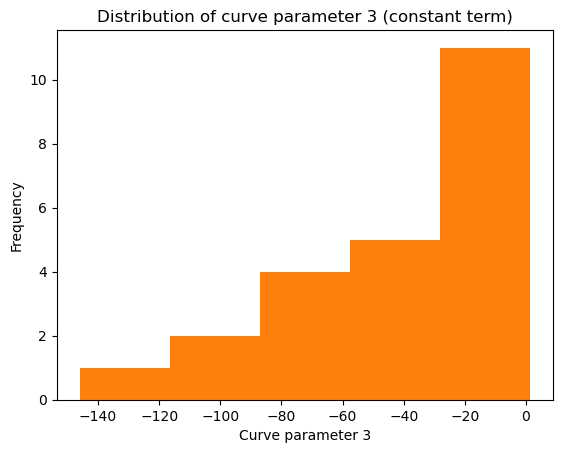

In [17]:
# fit a curve to the data in each bucket and plot the distribution of curve parameters

curve_params = []

for bucket in buckets:
    # Fit a curve to the data in the bucket
    curve = np.polyfit(ts_data["t"][bucket], ts_data["X"][bucket], 2)
    print(curve)
    curve_params.append(curve)

# Plot distribution of first parameter
plt.figure()
plt.hist([curve[0] for curve in curve_params], bins=5)
plt.xlabel("Curve parameter 1")
plt.ylabel("Frequency")
plt.title("Distribution of curve parameter 1 (coefficients of $x^2$)")

# Plot distribution of second parameter
plt.figure()
plt.hist([curve[1] for curve in curve_params], bins=5)
plt.xlabel("Curve parameter 2")
plt.ylabel("Frequency")
plt.title("Distribution of curve parameter 2 (coefficients of $x$)")

# Plot distribution of third parameter
# plt.figure(figsize=(15, 5))
plt.hist([curve[2] for curve in curve_params], bins=5)
plt.xlabel("Curve parameter 3")
plt.ylabel("Frequency")
plt.title("Distribution of curve parameter 3 (constant term)")

Closest x-intercept: 30.4224423190848
Number of steps to x-intercept: 6.4224423190848015
Number of x-steps to x-intercept: 6.4224423190848015


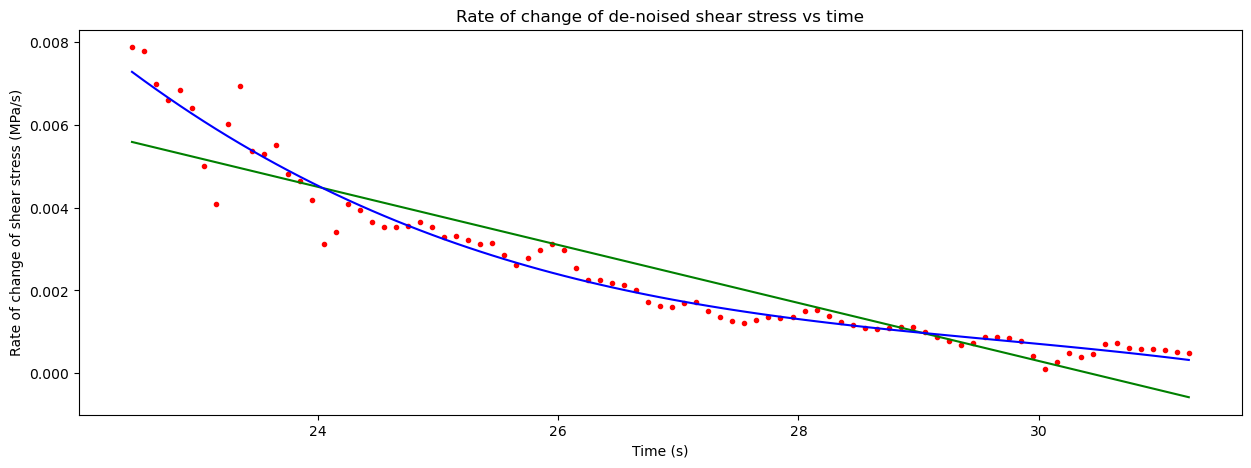

In [190]:
# Fit a line to the data in the first bucket
f = np.poly1d(
    np.polyfit(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), 1)
)

# Fit a curve to the data in the first bucket
p = np.poly1d(
    np.polyfit(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), 3)
)

# TODO: Problem is that this curve is specific to the bucket. We need to find a
# way to fit a curve to the entire signal.

# Plot the indexes in the first bucket
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), "r.")
# Plot the line of best fit
plt.plot(ts_data["t"][bucket], f(ts_data["t"][bucket]), "g")
# Plot the curve of best fit
plt.plot(ts_data["t"][bucket], p(ts_data["t"][bucket]), "b")
plt.xlabel("Time (s)")
plt.ylabel("Rate of change of shear stress (MPa/s)")
plt.title("Rate of change of de-noised shear stress vs time")


def interval_to_x_intercept(f, x1):
    # determine y1
    y1 = f(x1)

    # y = ax^3 + bx^2 + cx + d

    # Get x-intercept (roots of the polynomial)
    x_intercept = f.roots

    # Filter real roots
    real_roots = [root.real for root in x_intercept if np.isreal(root)]

    # Find closest x-intercept
    closest_x_intercept = min(real_roots, key=lambda x: abs(x - x1))

    print("Closest x-intercept:", closest_x_intercept)

    # Compute number of steps
    steps = abs(x1 - closest_x_intercept)
    print("Number of steps to x-intercept:", steps)
    return steps


steps_to_x_intercept = interval_to_x_intercept(f, 24)
print("Number of x-steps to x-intercept:", steps_to_x_intercept)

Closest x-intercept: 30.4224423190848
Number of steps to x-intercept: 0        30.371942
1        30.271942
2        30.171941
3        30.071941
4        29.971940
           ...    
1995    169.129055
1996    169.229056
1997    169.329056
1998    169.429057
1999    169.529057
Name: t, Length: 2000, dtype: float64


Text(0.5, 1.0, 'TTsF vs time')

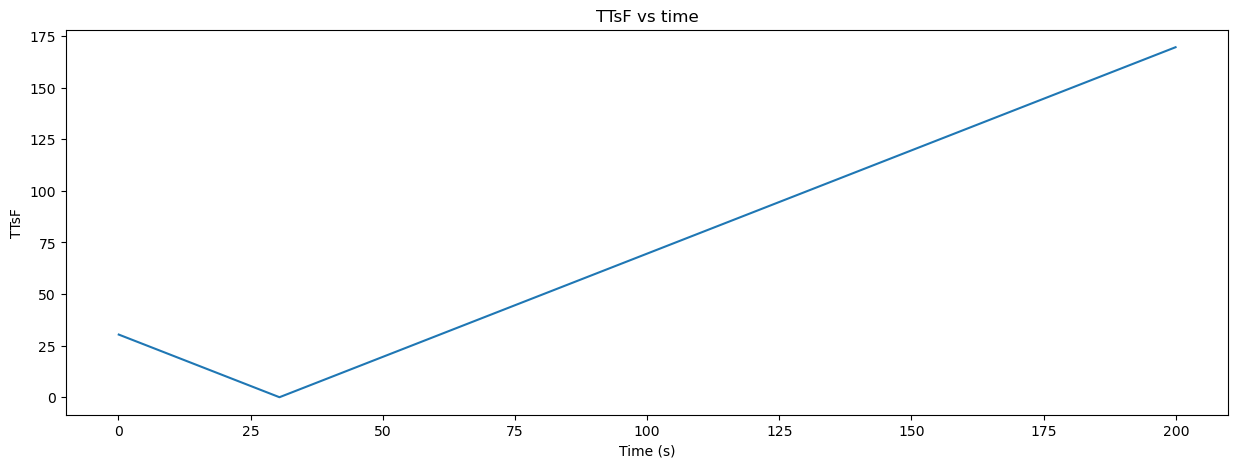

In [191]:
# This is function is only calculated based on one bucket, fit a line to the
# data across all the buckets

# Start by making an initial fit and then update the fit based on the data in
# each bucket

# for bucket in buckets:
#     f = np.poly1d(np.polyfit(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), 2))

# Take one of the fits that works e.g. the last one


# Predict the TTsF by passing the predict TTsF function across the entire ts_data
# DataFrame
ts_data["TTsF"] = interval_to_x_intercept(f, ts_data["t"])

# The function at the moment is fitted to the particular times in that bucket, we need to rest at the beginning of the bucket and then predict the time to the x-intercept - prep the function to work from time 0 and each bucket to start from time 0

# Plot the TTsF
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"], ts_data["TTsF"])
plt.xlabel("Time (s)")
plt.ylabel("TTsF")
plt.title("TTsF vs time")

NameError: name 'interval_to_x_intercept' is not defined

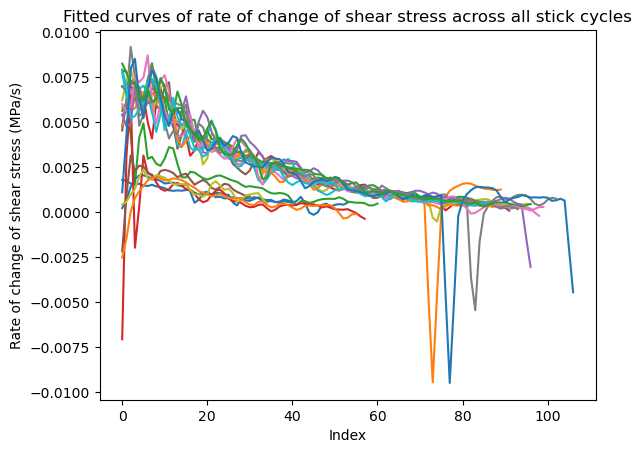

In [19]:
# Create collections of stick signal i.e. the signal indexes in each bucket
# We need all the stick signals to start from time 0 and then we can predict the time to the x-intercept
# We can then predict the time to the x-intercept for each stick signal
# We can then plot the time to the x-intercept for each stick signal

# Create a collection of stick signals
stick_signals = [ts_data["X"][bucket] for bucket in buckets]
derivatives = []

for stick_signal in stick_signals:
    derivatives.append(np.gradient(stick_signal))
    plt.plot(derivatives[-1])
plt.xlabel("Index")
plt.ylabel("Rate of change of shear stress (MPa/s)")
plt.title(
    "Fitted curves of rate of change of shear stress across all stick cycles"
)

# Fit a polynomial to the derivatives[3] signal, do not use the actual time in the time series, use the index of the time series
f = np.poly1d(np.polyfit(np.arange(len(derivatives[3])), derivatives[3], 3))

# Predict the TTsF by passing the predict TTsF function across the entire ts_data
# DataFrame. Rest the function to start from time 0 and then predict the time to the x-intercept

# use the index of the bucket not the index of the time series which is the value of the time series
# the x_1 needs to be the index of the bucket not the value of the time series
# TTsF = []
# for bucket in buckets:
#     for i in range(len(buckets)):
#         TTsF.append(interval_to_x_intercept(f, i))

signal = []

# Do this for the whole signal set TTsF val to 0 when not in a stick phase
# for i in range(len(ts_data)):
#     if i in indexes:
#         # find the bucket that i is in and use that index as x1
#         print("I am in a stick phase: ", i)
#         for j in range(len(buckets)):
#             if i in buckets[j]:
#                 print("I am in bucket", j)
#                 for k in range(len(buckets[j])):
#                     signal.append(interval_to_x_intercept(f, k))
#                 i = len(buckets[j])
#                 print("jump to", i)
#     else:
#         signal.append(0)

for bucket in buckets:
    for i in range(len(buckets)):
        signal.append(interval_to_x_intercept(f, i))

# Make signal the same length as the time series add any missing value i.e. values not in a bucket as 0
# for i in range(len(ts_data)):
#     for j in range(len(buckets)):
#         if i not in buckets[j]:
#             signal.insert(i, 0)


# print(len(signal))
# print(len(ts_data))

# Plot the TTsF
plt.figure(figsize=(15, 5))
plt.plot(signal, ".")
plt.xlabel("Time (s)")

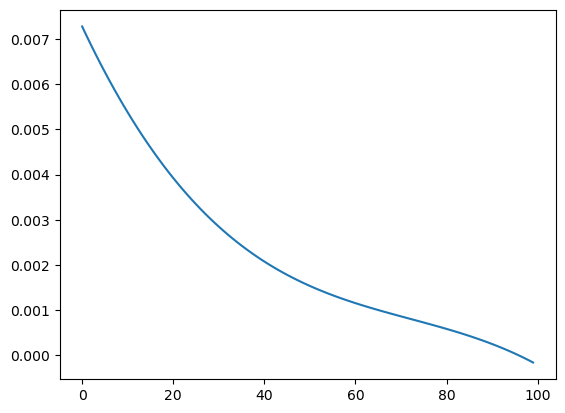

In [193]:
# plot the fit
plt.plot(f(np.arange(0, 100)))